### Install Required Packages

We would be running `Stable Diffusion 2` so enable `GPU` under `View Resources > Change runtime type`

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-bdce8e67-2a7b-f9d6-d0f7-1046b84fe61d)


In [2]:
%%capture
!pip install diffusers
!pip install accelerate
!pip install daam==0.0.12
!pip install git+https://github.com/RishiDarkDevil/daam-i2i.git
!pip install git+https://github.com/RishiDarkDevil/TITAN.git

### Import Necessary Libraries

We will load the necessary libraries required for generating DAAM outputs for input prompts.

In [3]:
# General
import requests
from io import BytesIO

# Plotting
from matplotlib import pyplot as plt

# Data Handling
import numpy as np

# Image Processing
import cv2
from PIL import Image

# Image Generation
from diffusers import StableDiffusionImg2ImgPipeline

# Heatmap generation
import daam
import daami2i

# Model
import torch

# annotations
import titan

### Load Model

In [4]:
DEVICE = 'cuda' # device

Now, let's load the `stabilityai/stable-diffusion-2-base` diffusion model.

In [5]:
STRENGTH = 0.3

In [6]:
model = StableDiffusionImg2ImgPipeline.from_pretrained('stabilityai/stable-diffusion-2-base')
model = model.to(DEVICE) # Set it to something else if needed, make sure DAAM supports that

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

### DAAM Image Attention

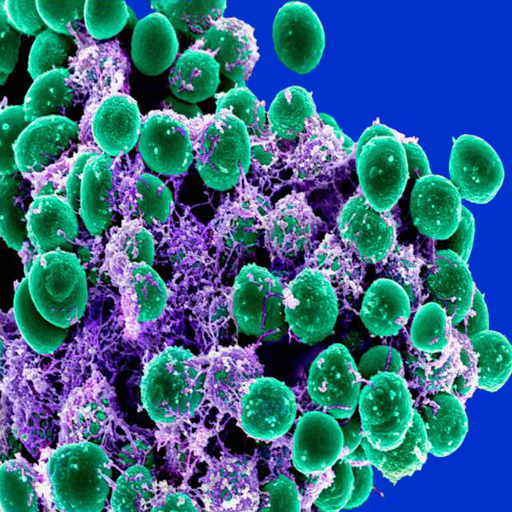

In [7]:
# Image
url = "https://segment-anything.com/assets/gallery/18135.jpg"

response = requests.get(url)
init_img = Image.open(BytesIO(response.content)).convert("RGB")
# init_img = Image.open('img.png').convert("RGB")
init_img = init_img.resize((512, 512))
init_img

In [8]:
prompt = ['green particles']
objects = ['green particles']

In [9]:
# processed_prompt = titan.PromptHandler().clean_prompt(prompt)

In [10]:
# processed_prompt

In [11]:
with daam.trace(model) as daam_trc:
  with daami2i.trace(model) as daami2i_trc:
    output_image = model(prompt=prompt, init_image=init_img, strength=STRENGTH, guidance_scale=7.5).images[0]
    image_global_heat_map = daami2i_trc
    word_global_heat_map = daam_trc

  0%|          | 0/16 [00:00<?, ?it/s]

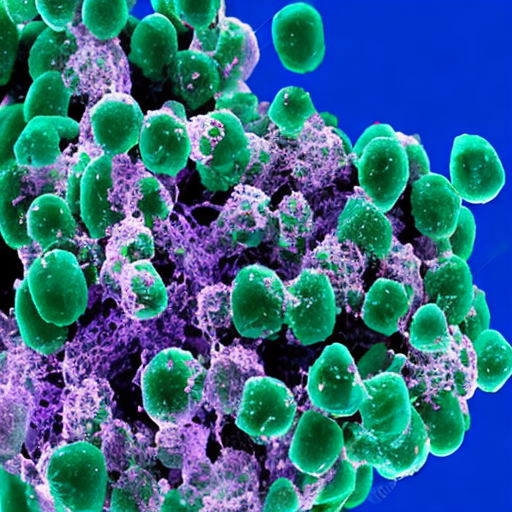

In [12]:
output_image

### Visualize Heatmaps

In [13]:
# Image2Image Attention Heatmap Aggregation for 1st Layer of UNet
image_global_heat_map = image_global_heat_map.compute_global_heat_map([1], None, None)
# Text2Image Attention Heatmap Aggregation for all Layers of UNet
word_global_heat_map = word_global_heat_map.compute_global_heat_map(None, None, None)

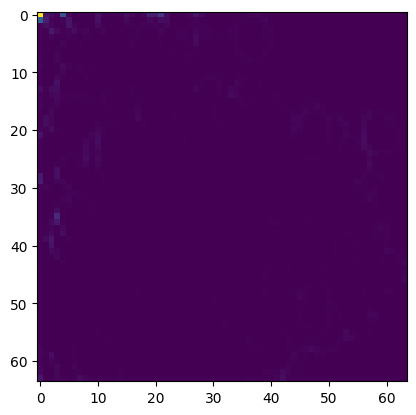

In [14]:
plt.imshow(image_global_heat_map.compute_pixel_heat_map(0).heatmap)

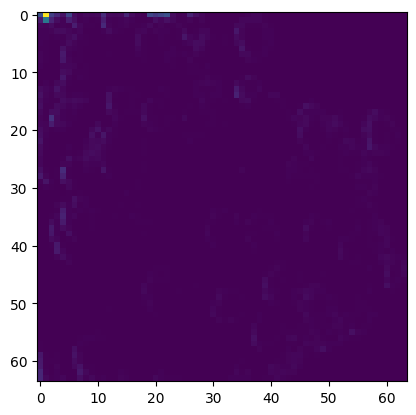

In [15]:
plt.imshow(image_global_heat_map.compute_pixel_heat_map(1).heatmap)

In [16]:
word_heatmap = word_global_heat_map.compute_word_heat_map(objects[-1]).heatmap

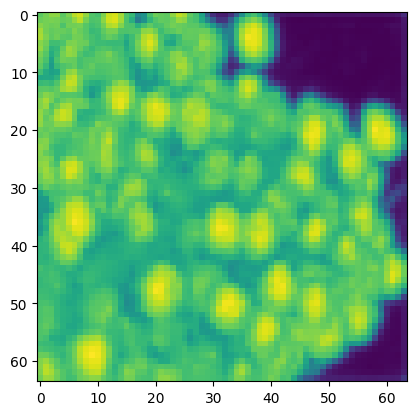

In [17]:
# Text Guided
plt.imshow(image_global_heat_map.compute_guided_heat_map(word_heatmap).heatmap)

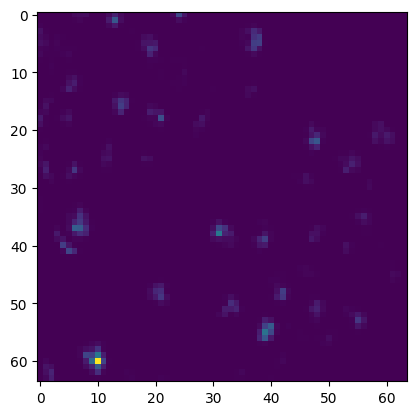

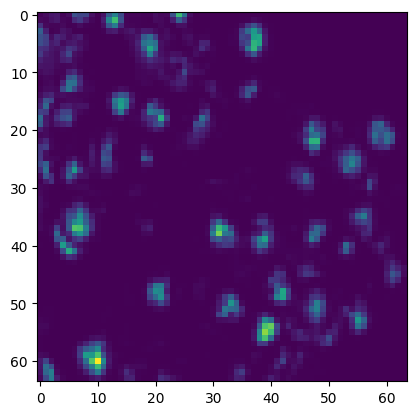

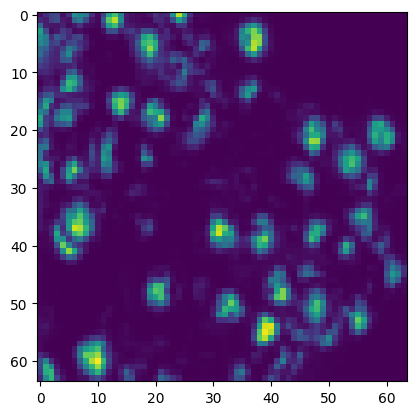

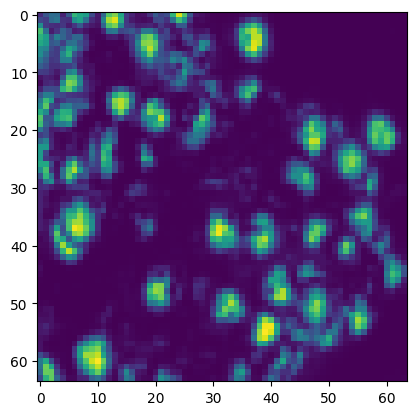

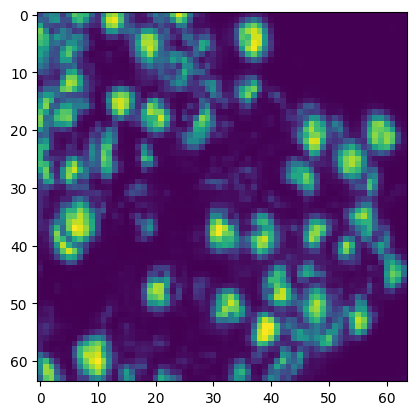

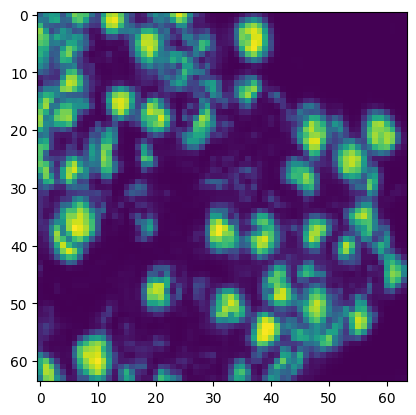

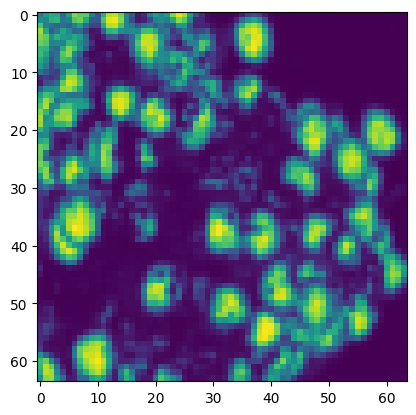

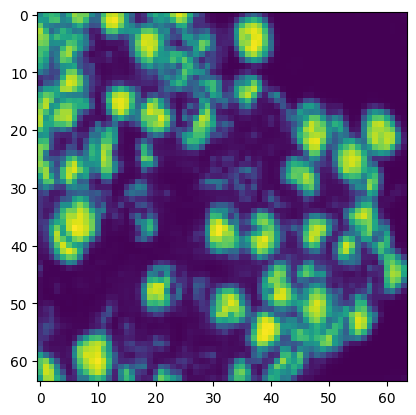

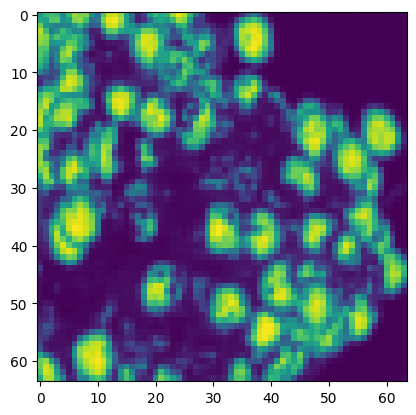

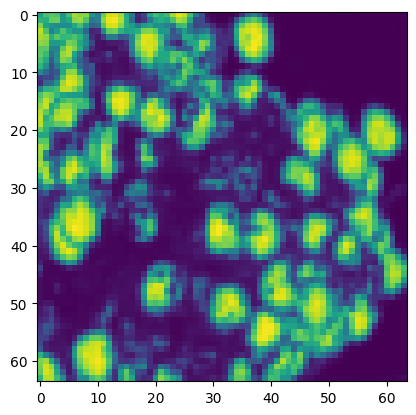

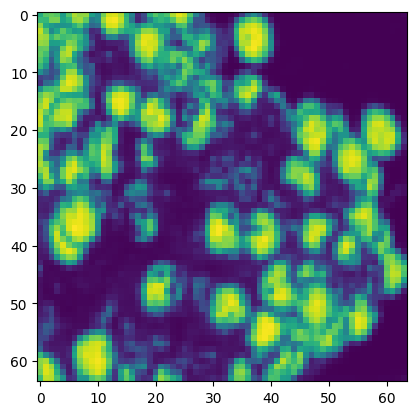

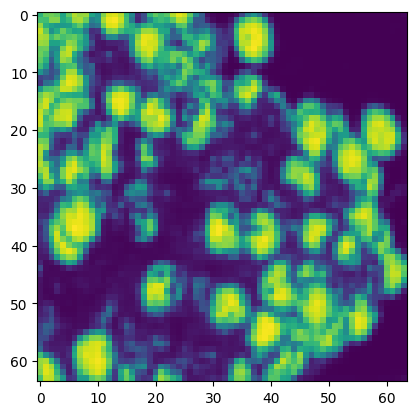

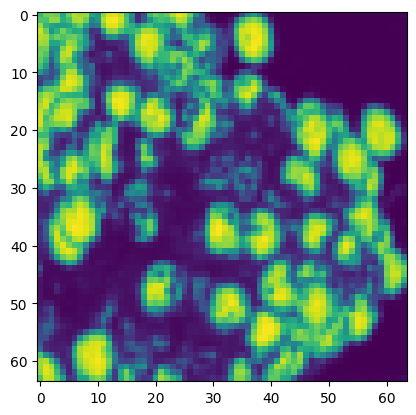

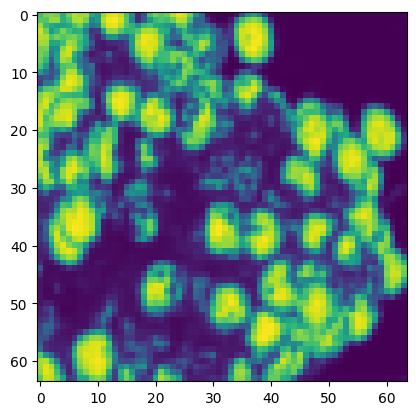

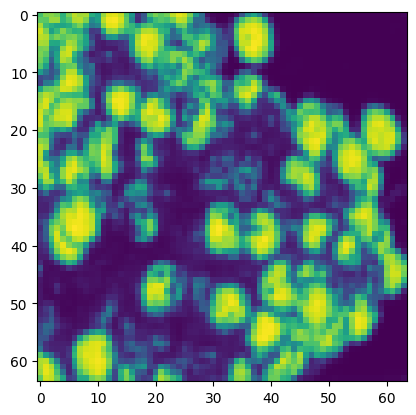

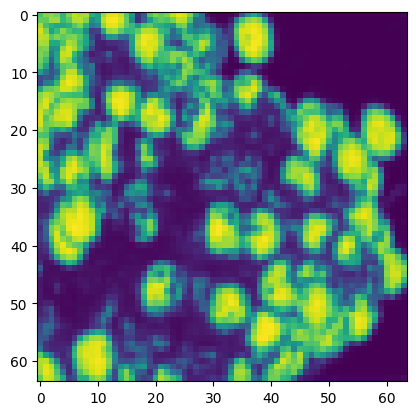

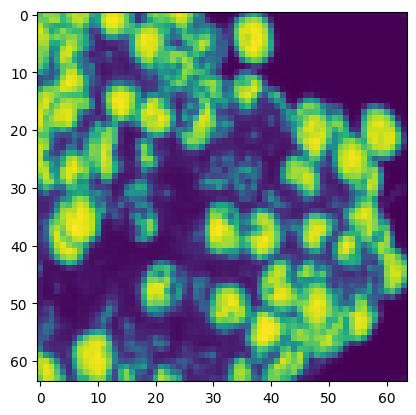

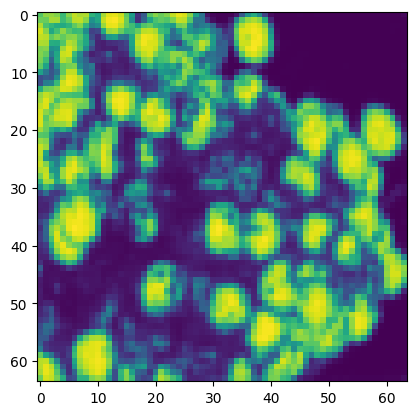

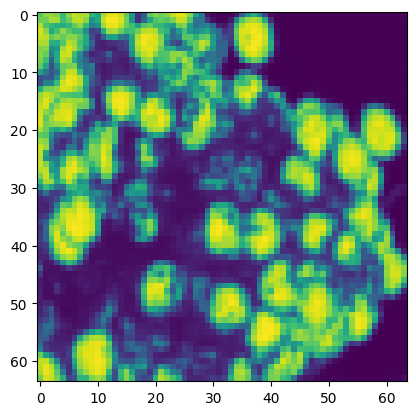

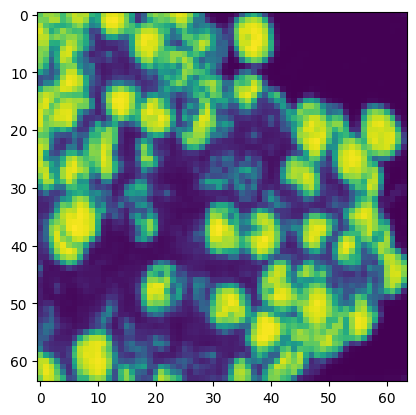

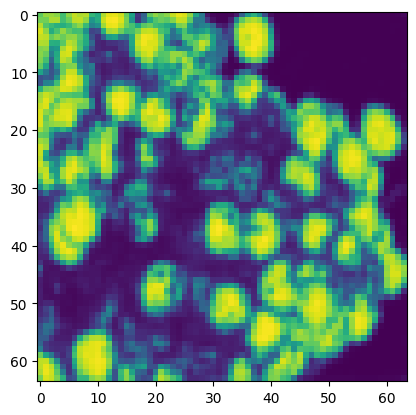

In [18]:
# Pixel Attention Diffusion Image diffusion
NUM_DIFFUSE = 20
PIXEL_ID = 60*64 + 10 # Enter Pixel ID
heatmap = image_global_heat_map.compute_pixel_diffused_heat_map(PIXEL_ID, 'thresholding', NUM_DIFFUSE, 0.002, True)

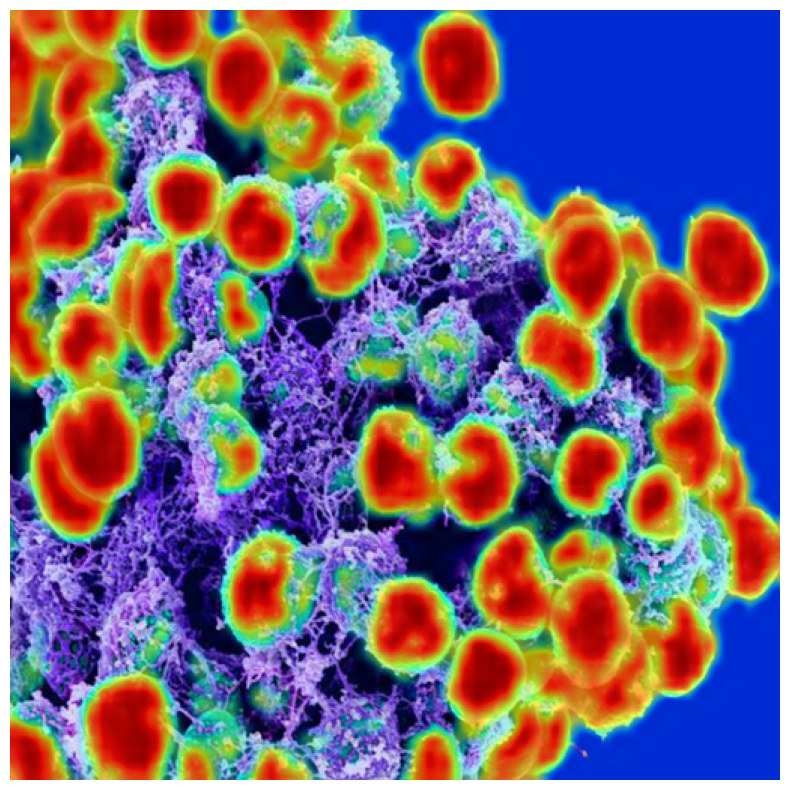

In [19]:
heatmap.plot_overlay(init_img)

In [20]:
heatmap = image_global_heat_map.compute_diffused_heat_map('thresholding', NUM_DIFFUSE, 0.002)

100%|██████████| 20/20 [00:45<00:00,  2.30s/it]


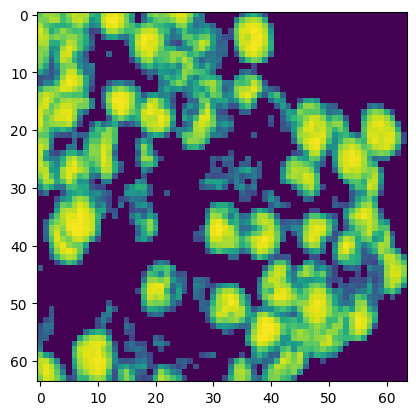

In [21]:
plt.imshow(heatmap.compute_pixel_heat_map(PIXEL_ID).heatmap)

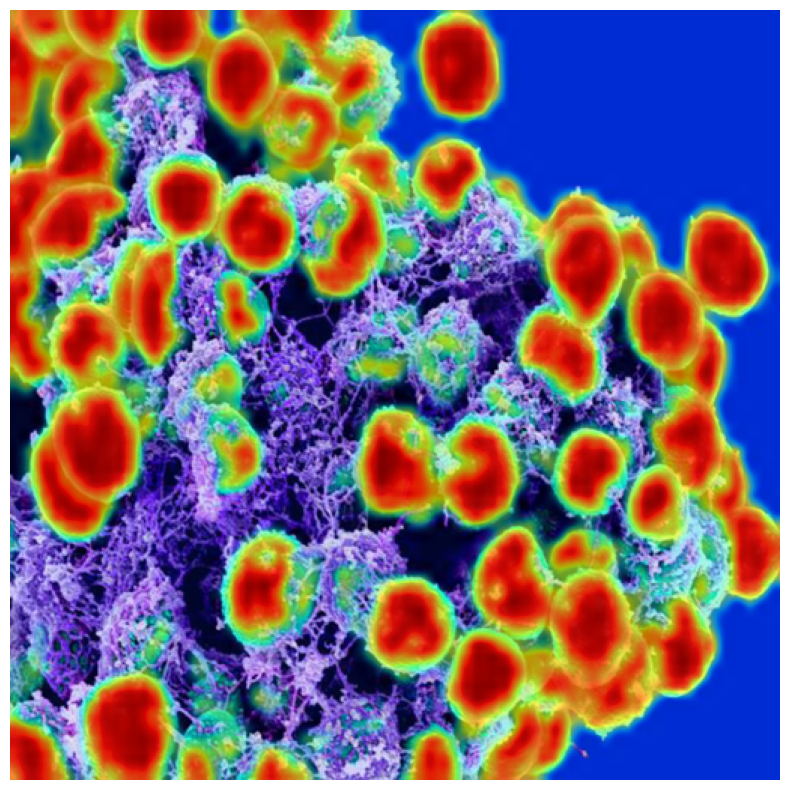

In [22]:
heatmap.compute_pixel_heat_map(PIXEL_ID).plot_overlay(init_img)

In [23]:
object_annotator = titan.ObjectAnnotator()

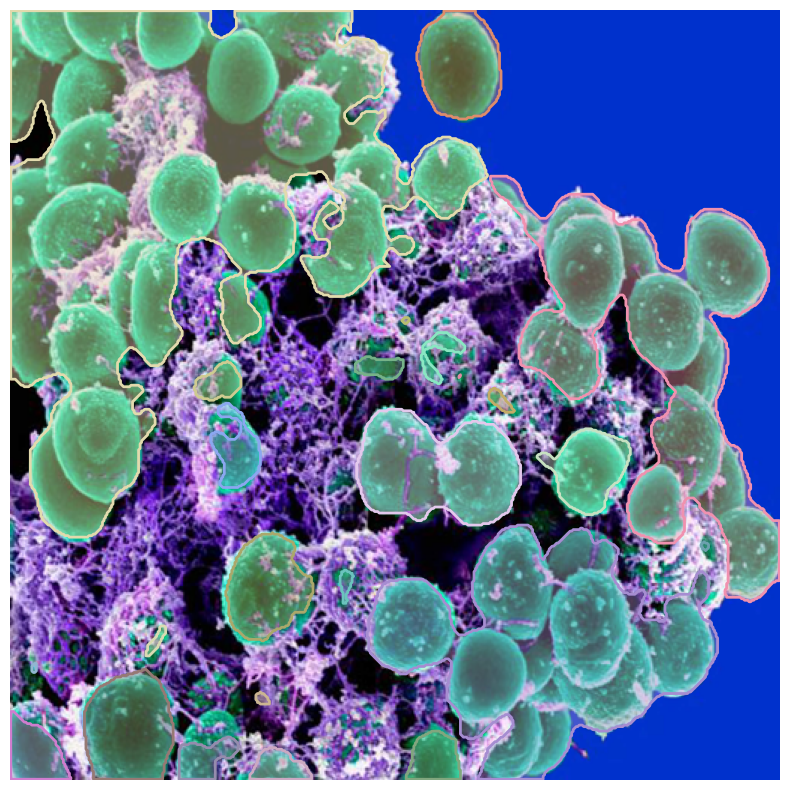

In [24]:
ann = object_annotator.wordheatmap_to_annotations(heatmap.compute_pixel_heat_map(PIXEL_ID).expand_as(output_image).numpy(), use_nms=False, skip_small_filters=True)
object_annotator.show_annotations(np.asarray(init_img), ann, draw_bbox=False)

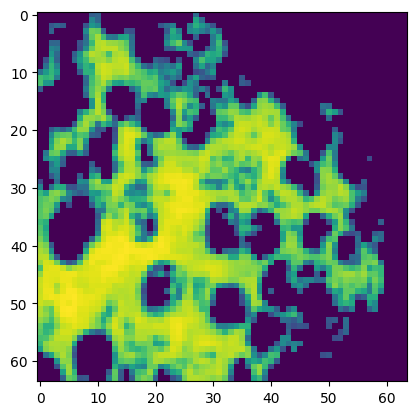

In [27]:
plt.imshow(heatmap.compute_pixel_heat_map(47*64+10).heatmap)

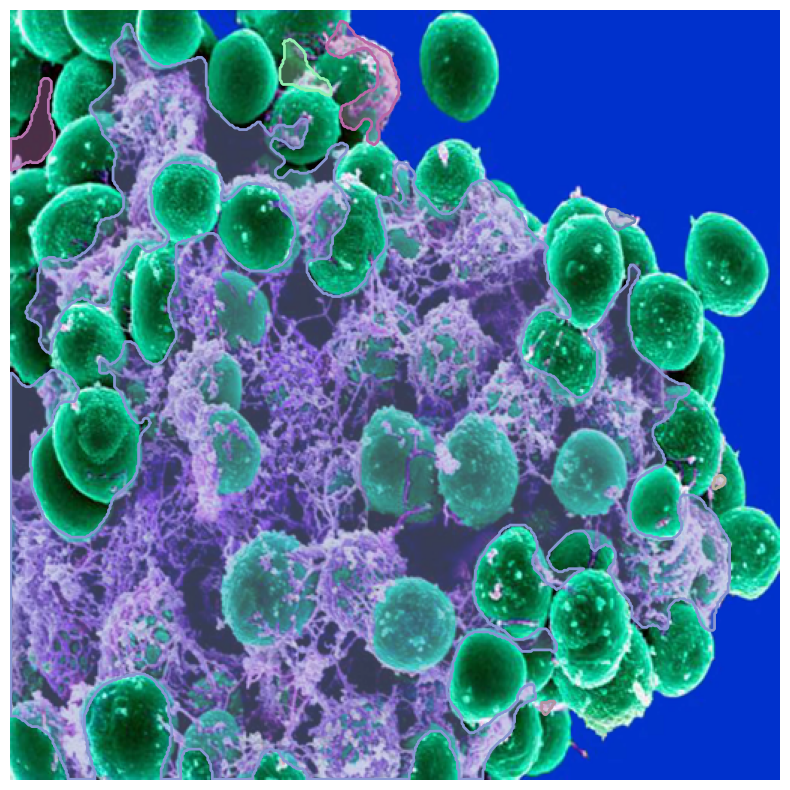

In [26]:
ann = object_annotator.wordheatmap_to_annotations(heatmap.compute_pixel_heat_map(47*64+10).expand_as(output_image).numpy(), use_nms=False, skip_small_filters=True)
object_annotator.show_annotations(np.asarray(init_img), ann, draw_bbox=False)

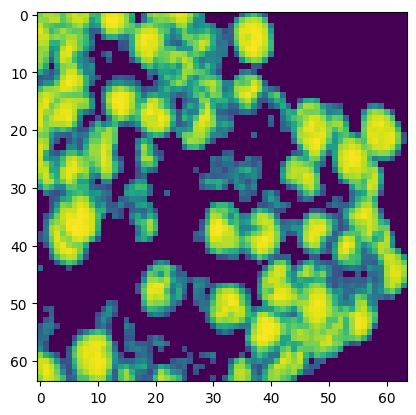

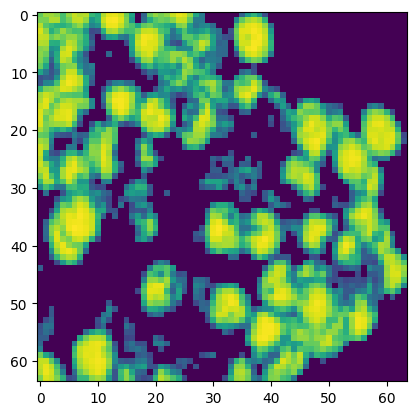

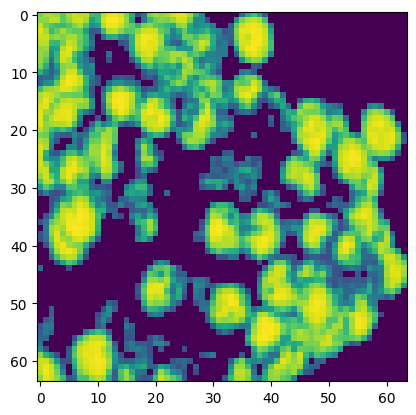

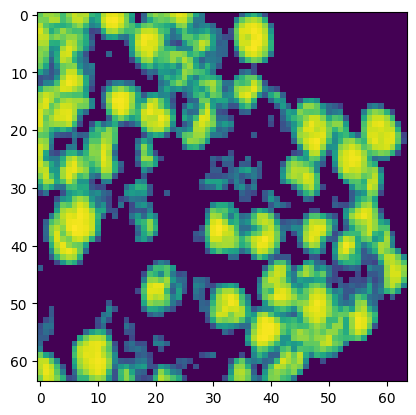

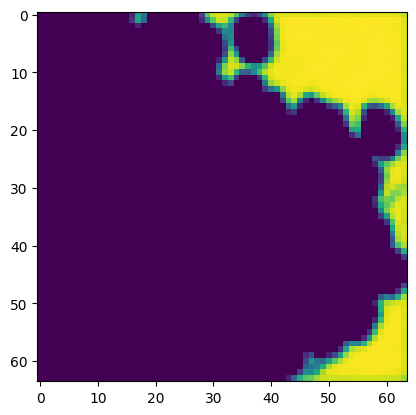

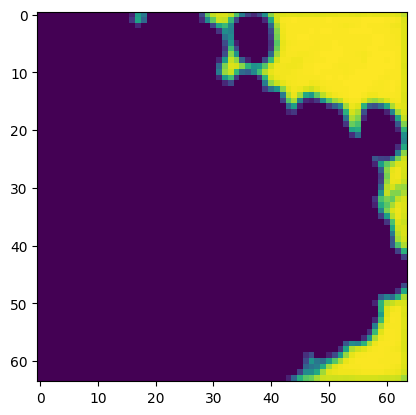

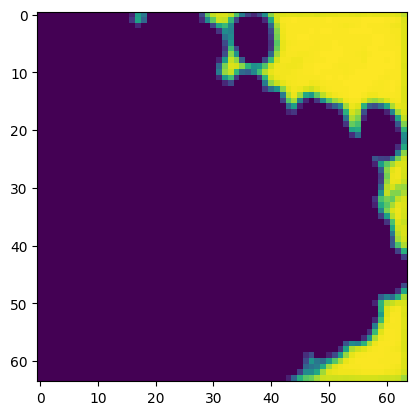

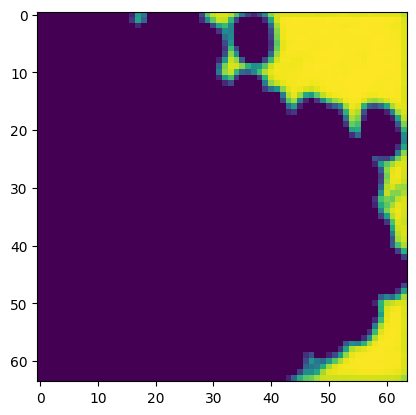

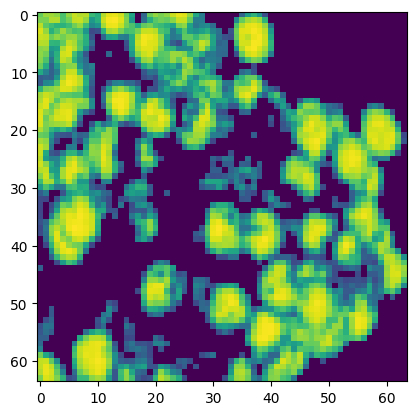

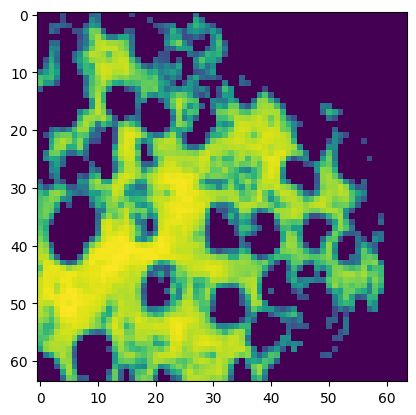

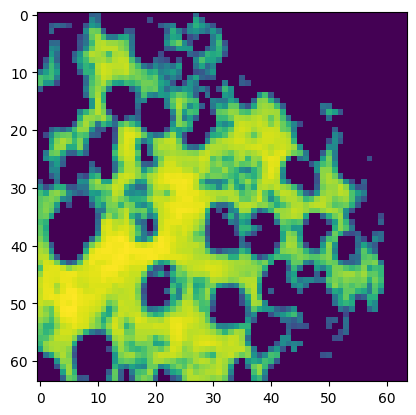

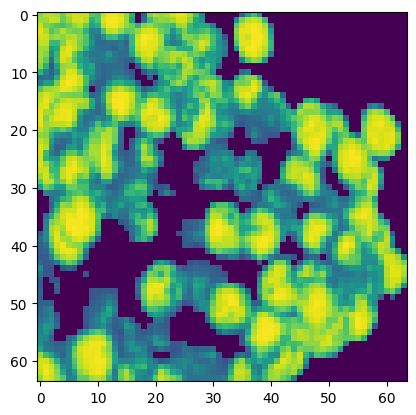

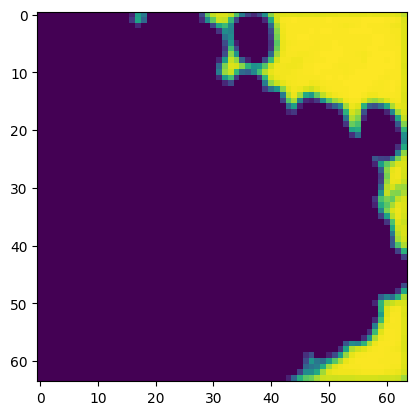

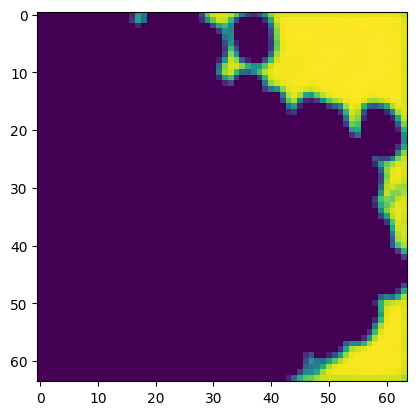

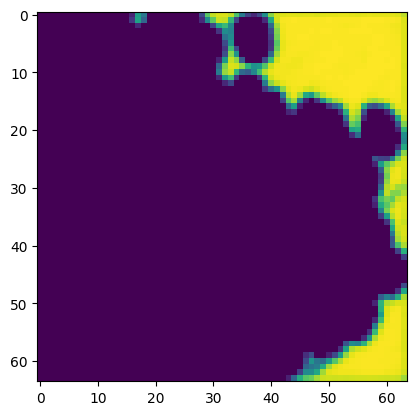

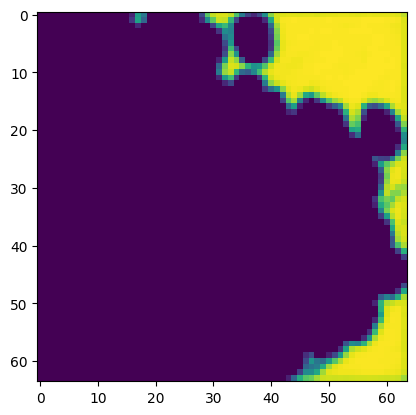

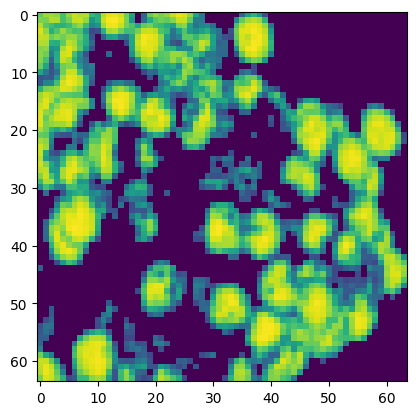

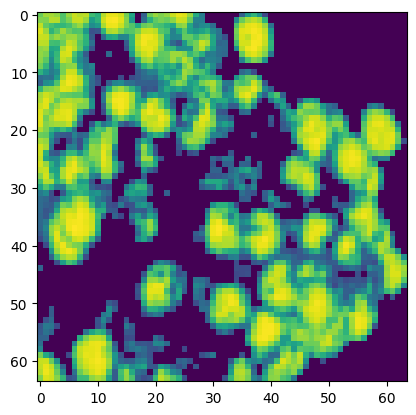

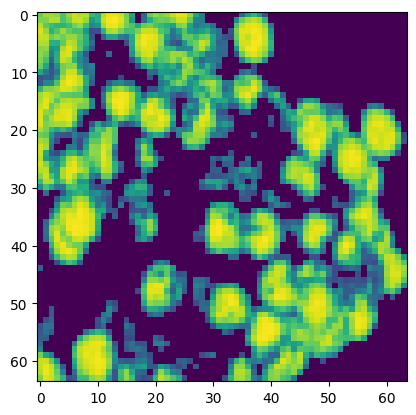

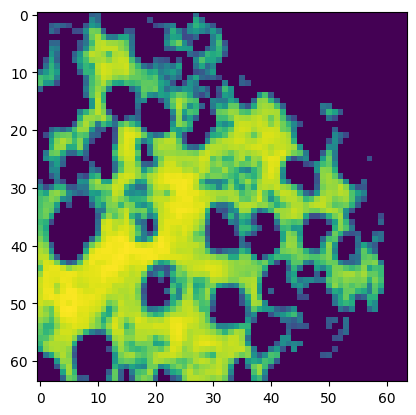

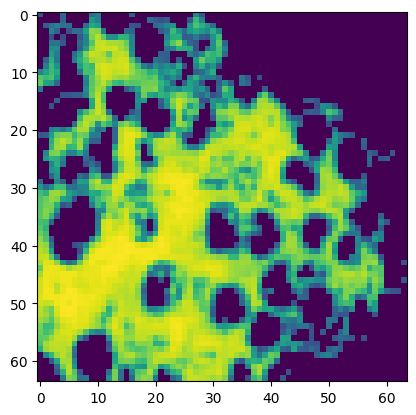

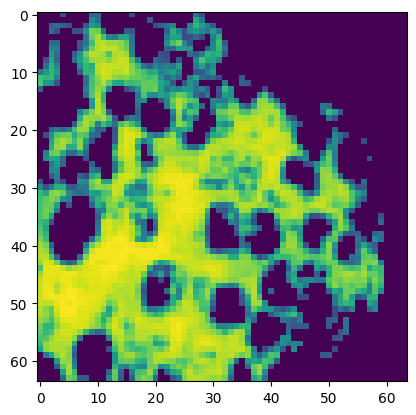

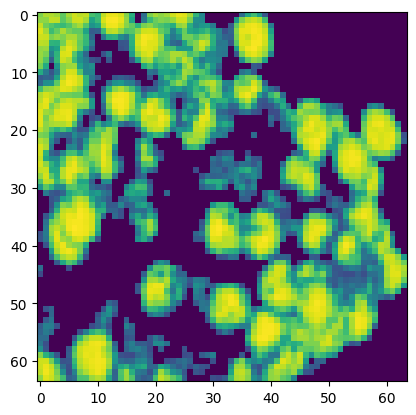

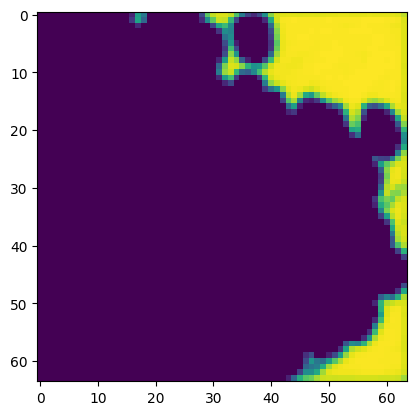

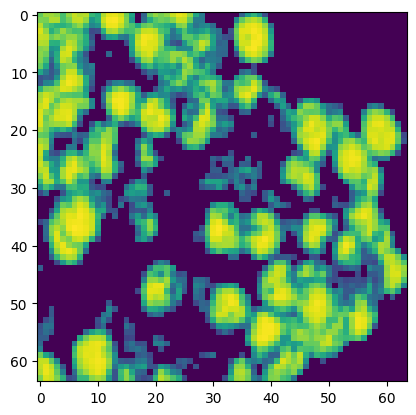

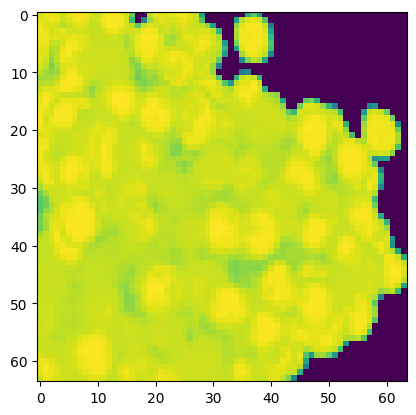

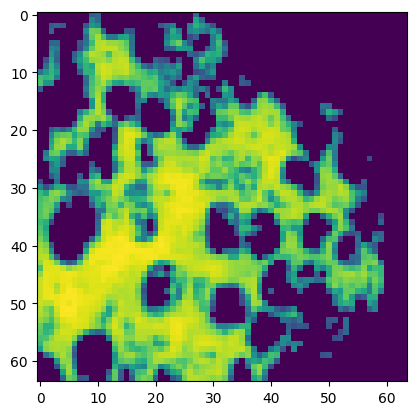

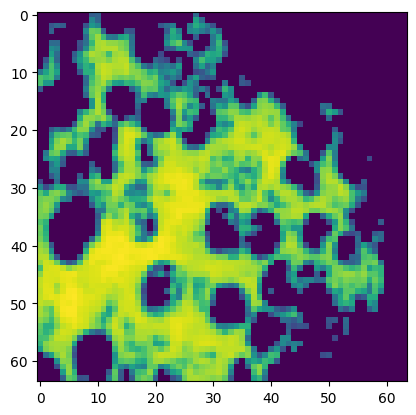

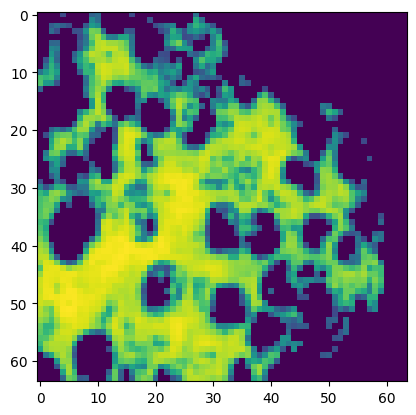

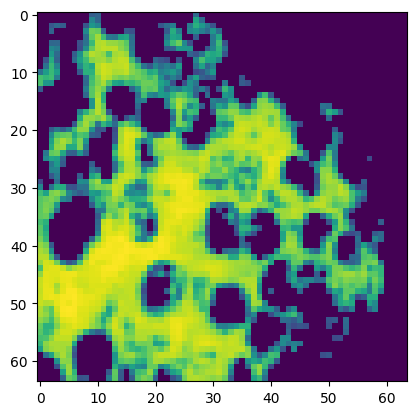

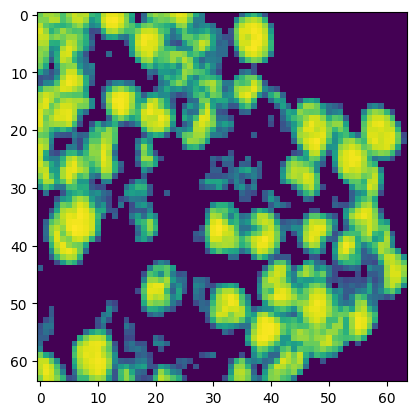

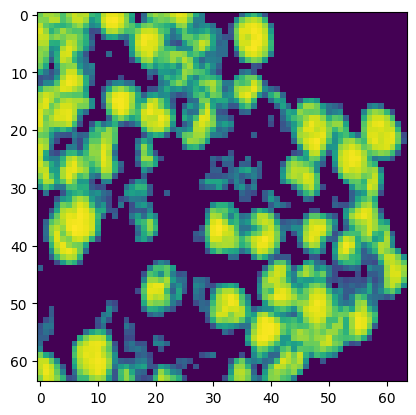

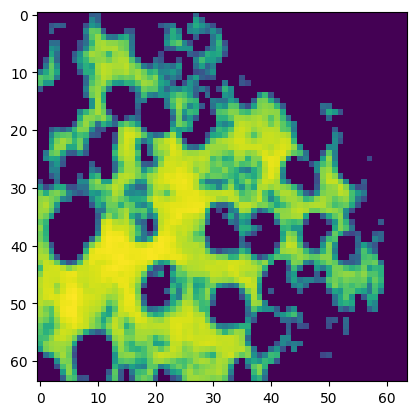

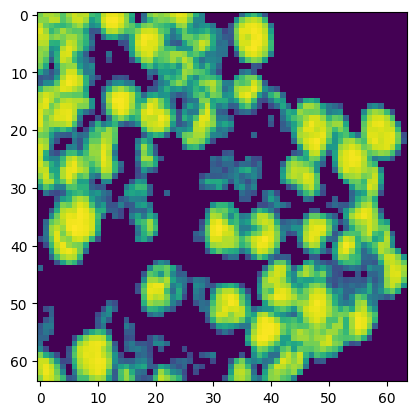

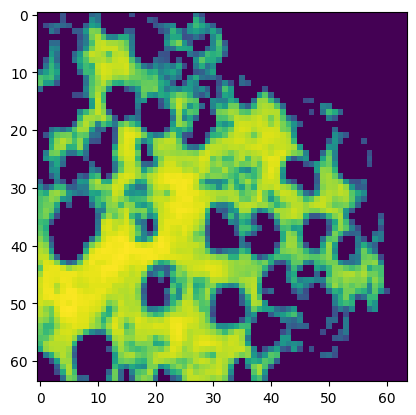

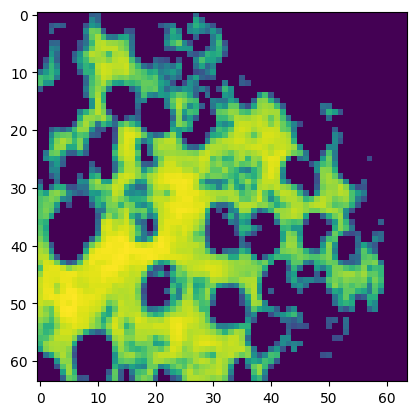

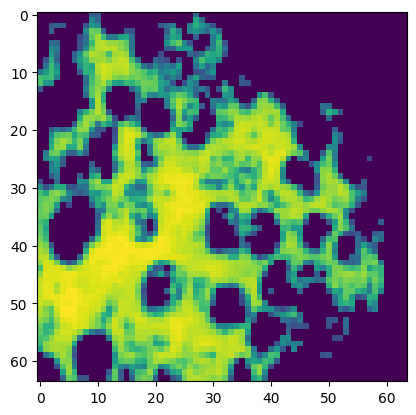

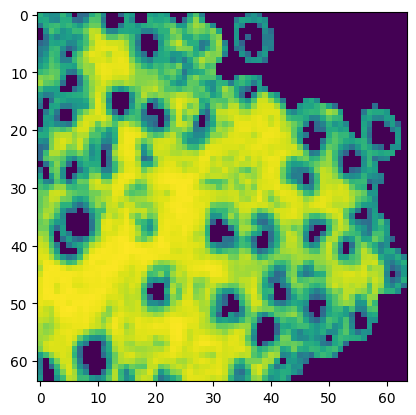

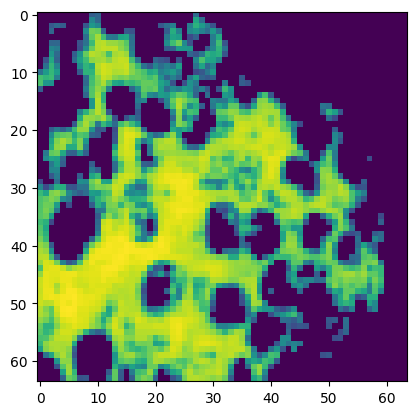

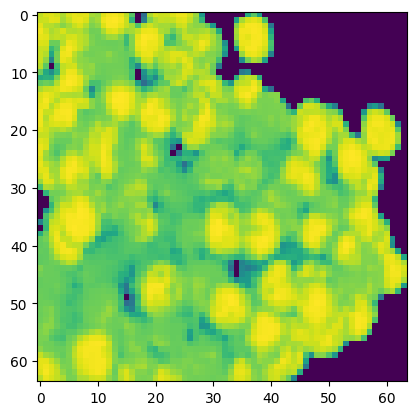

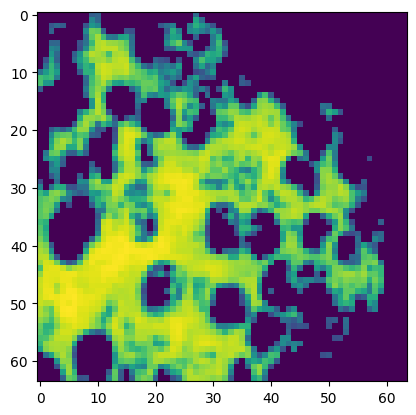

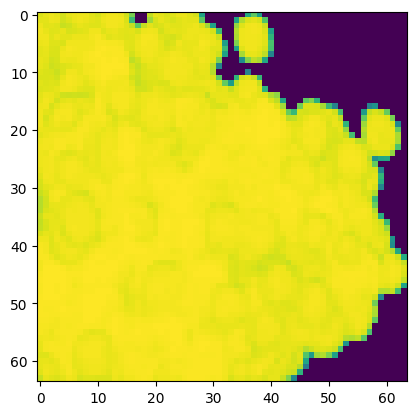

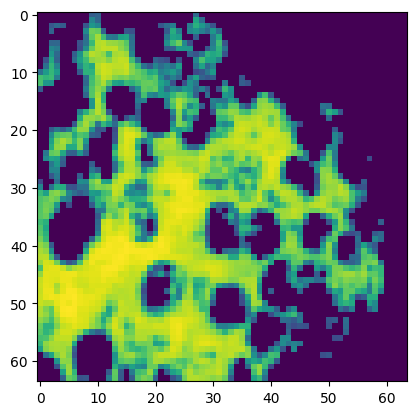

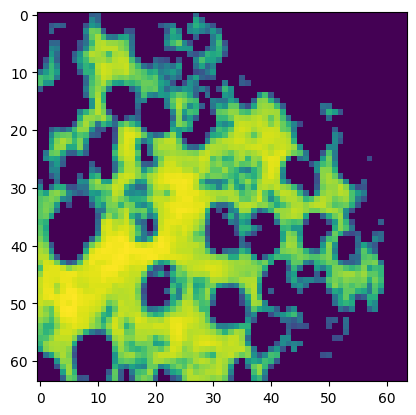

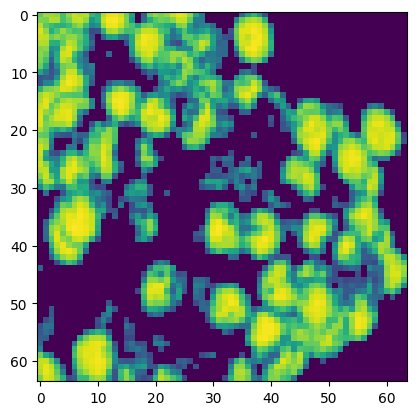

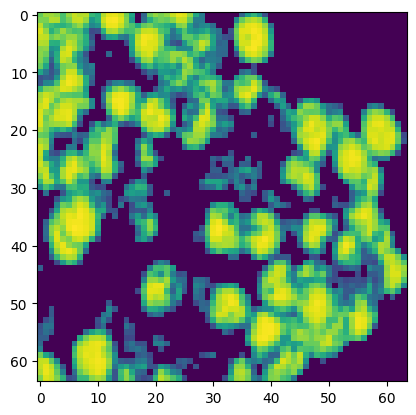

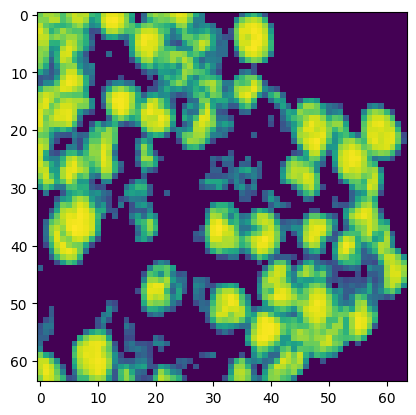

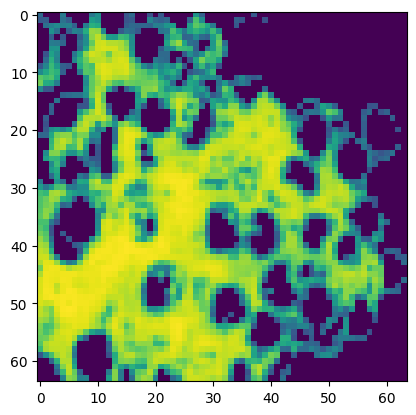

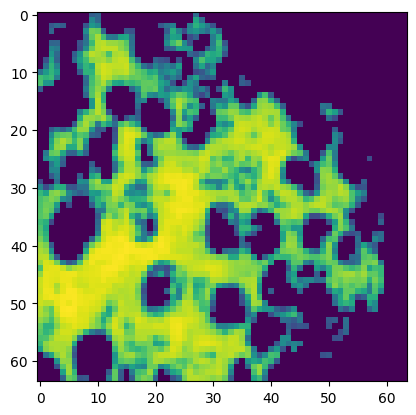

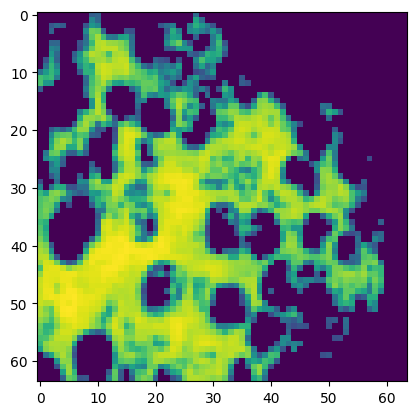

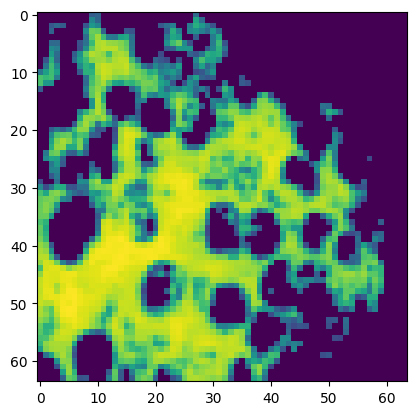

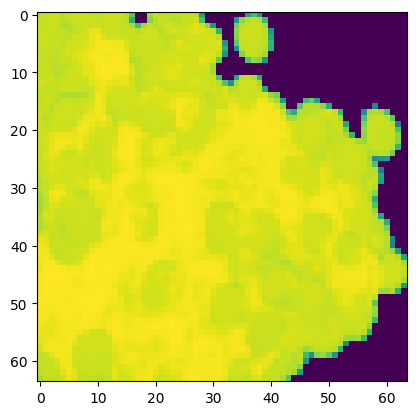

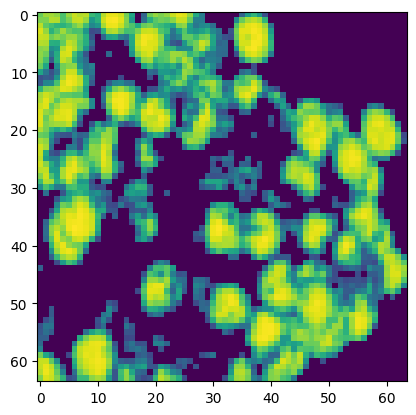

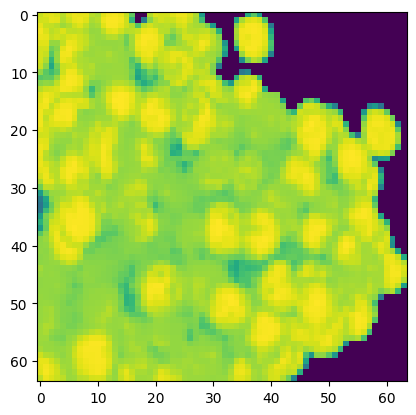

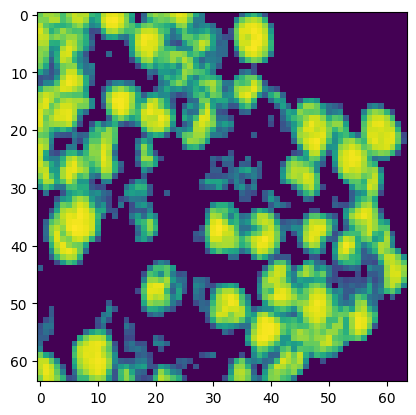

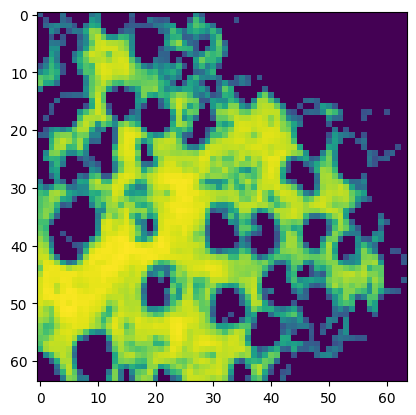

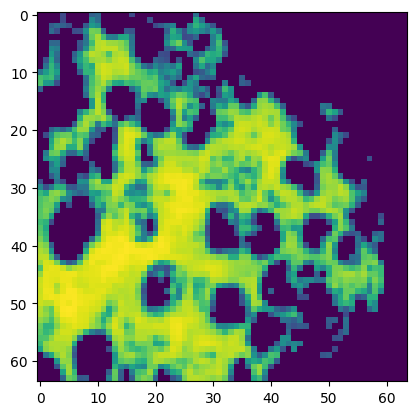

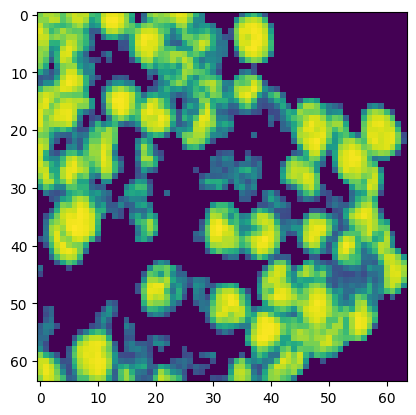

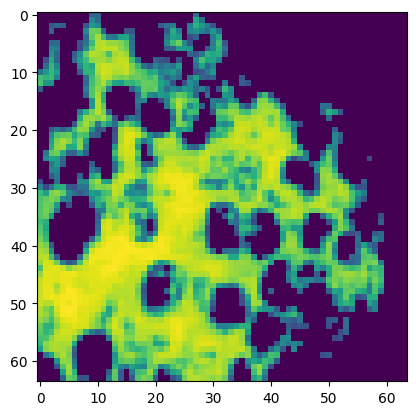

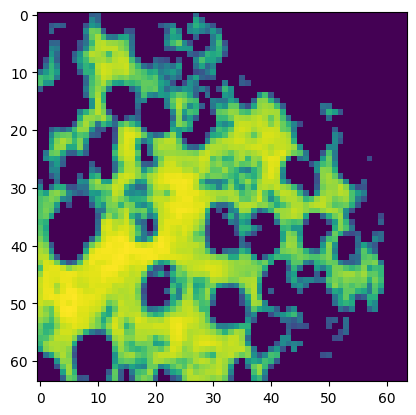

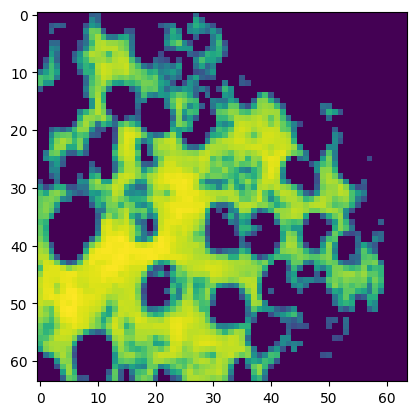

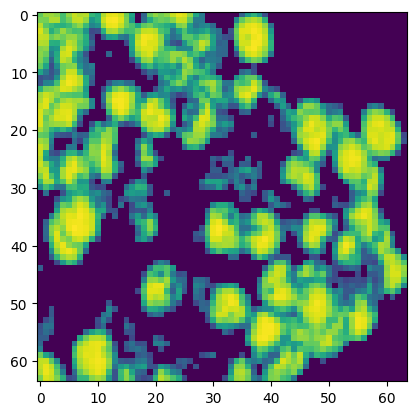

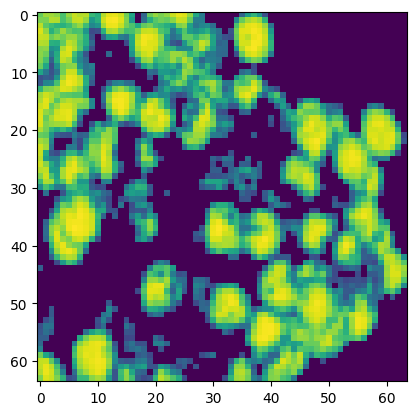

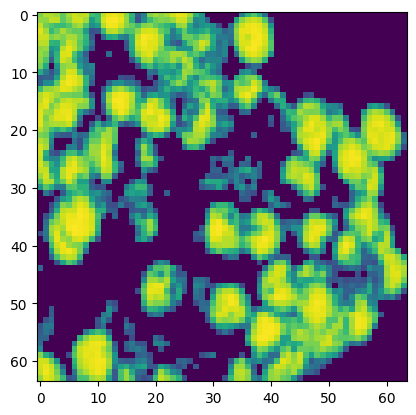

In [30]:
for i in range(0, 64, 8):
  for j in range(0, 64, 8):
    plt.imshow(heatmap.compute_pixel_heat_map(i*64+j).heatmap)
    plt.show()